## Dependencies

In [1]:
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [4]:
config = {
  "HEIGHT": 512,
  "WIDTH": 512,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 15,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 1,
  "TTA_STEPS": 15,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-512x512'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 512,
 'WIDTH': 512,
 'CHANNELS': 3,
 'BATCH_SIZE': 128,
 'EPOCHS': 15,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 5,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 1,
 'TTA_STEPS': 15,
 'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'DATASET_PATH': 'melanoma-512x512'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image['input_image'] = data_augment_spatial(image['input_image'])
      else: # Rotate
        image['input_image'] = data_augment_rotate(image['input_image'])

    if p_crop >= .6: # Crops
      image['input_image'] = data_augment_crop(image['input_image'])

    if p_spatial2 >= .5: 
      if p_spatial2 >= .75: # Shift
        image['input_image'] = data_augment_shift(image['input_image'])
      else: # Shear
        image['input_image'] = data_augment_shear(image['input_image'])
        
    if p_pixel >= .6: # Pixel-level transforms
      if p_pixel >= .9:
        image['input_image'] = data_augment_hue(image['input_image'])
      elif p_pixel >= .8:
        image['input_image'] = data_augment_saturation(image['input_image'])
      elif p_pixel >= .7:
        image['input_image'] = data_augment_contrast(image['input_image'])
      else:
        image['input_image'] = data_augment_brightness(image['input_image'])

    if p_rotation >= .5: # Rotation
      image['input_image'] = data_augment_rotation(image['input_image'])
    
    if p_cutout >= .5: # Cutout
      image['input_image'] = data_augment_cutout(image['input_image'])
    
    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image['input_image'] = data_augment_spatial(image['input_image'])
      else: # Rotate
        image['input_image'] = data_augment_rotate(image['input_image'])

    if p_crop >= .6: # Crops
      image['input_image'] = data_augment_crop(image['input_image'])

    if p_spatial2 >= .5: 
      if p_spatial2 >= .75: # Shift
        image['input_image'] = data_augment_shift(image['input_image'])
      else: # Shear
        image['input_image'] = data_augment_shear(image['input_image'])

    if p_rotation >= .5: # Rotation
      image['input_image'] = data_augment_rotation(image['input_image'])
    
    return image, label


def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_hue(image, max_delta=.02):
    image = tf.image.random_hue(image, max_delta)
    return image

def data_augment_saturation(image, lower=.8, upper=1.2):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .8:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
    elif p_crop > .6:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    elif p_crop > .4:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    elif p_crop > .2:
        image = tf.image.central_crop(image, central_fraction=.8)
    else:
        image = tf.image.central_crop(image, central_fraction=.7)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .05), int(config['HEIGHT'] * .05)), 
                        max_mask_size=(int(config['HEIGHT'] * .25), int(config['HEIGHT'] * .25))):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

In [8]:
lr_min = 1e-6
# lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24519 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
# hold_max_steps = 0
# step_decay = .8
# step_size = steps_per_epoch * 1

# rng = [i for i in range(0, total_steps, 32)]
# y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
#                                warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
#                                lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

# sns.set(style="whitegrid")
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [10]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [11]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]

# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint(model_path, monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            optimizer = tfa.optimizers.RectifiedAdam(lr=lr_max,
                                                     total_steps=total_steps,
                                                     warmup_proportion=(warmup_steps / total_steps),
                                                     min_lr=lr_min)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[checkpoint, es],
#                             class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights('last_' + model_path)

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1
165232640/165226952 [==============================] - 15s 0us/step
Epoch 1/15
204/204 - 193s - loss: 0.1802 - auc: 0.5498 - val_loss: 0.1755 - val_auc: 0.6412
Epoch 2/15
204/204 - 154s - loss: 0.1717 - auc: 0.7751 - val_loss: 0.1683 - val_auc: 0.8330
Epoch 3/15
204/204 - 153s - loss: 0.1681 - auc: 0.8118 - val_loss: 0.1677 - val_auc: 0.8578
Epoch 4/15
204/204 - 155s - loss: 0.1677 - auc: 0.8217 - val_loss: 0.1652 - val_auc: 0.8724
Epoch 5/15
204/204 - 151s - loss: 0.1679 - auc: 0.8415 - val_loss: 0.1630 - val_auc: 0.8749
Epoch 6/15
204/204 - 161s - loss: 0.1665 - auc: 0.8563 - val_loss: 0.1637 - val_auc: 0.8803
Epoch 7/15
204/204 - 150s - loss: 0.1643 - auc: 0.8682 - val_loss: 0.1632 - val_auc: 0.8671
Epoch 8/15
204/204 - 150s - loss: 0.1634 - auc: 0.8806 - val_loss: 0.1641 - val_auc: 0.8743
Epoch 9/15
204/204 - 155s - loss: 0.1606 - auc: 0.9004 - val_loss: 0.1645 - val_auc: 0.8849
Epoch 10/15
204/204 - 149s - loss: 0.1590 - auc: 0.9065 - val_loss: 0.1634 - val_auc: 0.8623
Ep

## Model loss graph

Fold: 1


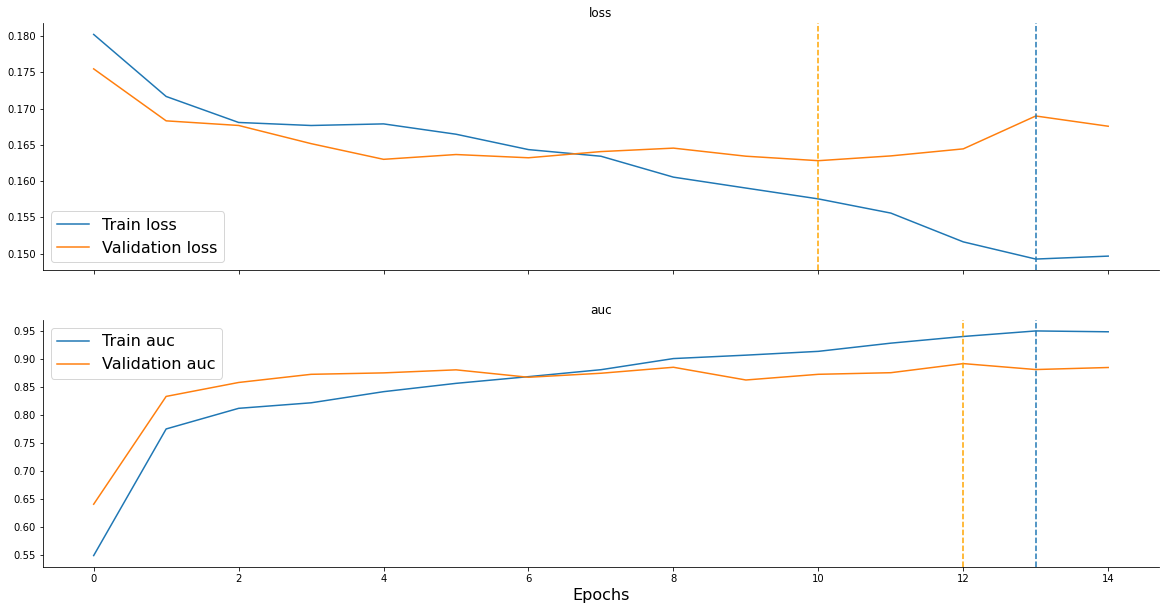

In [12]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

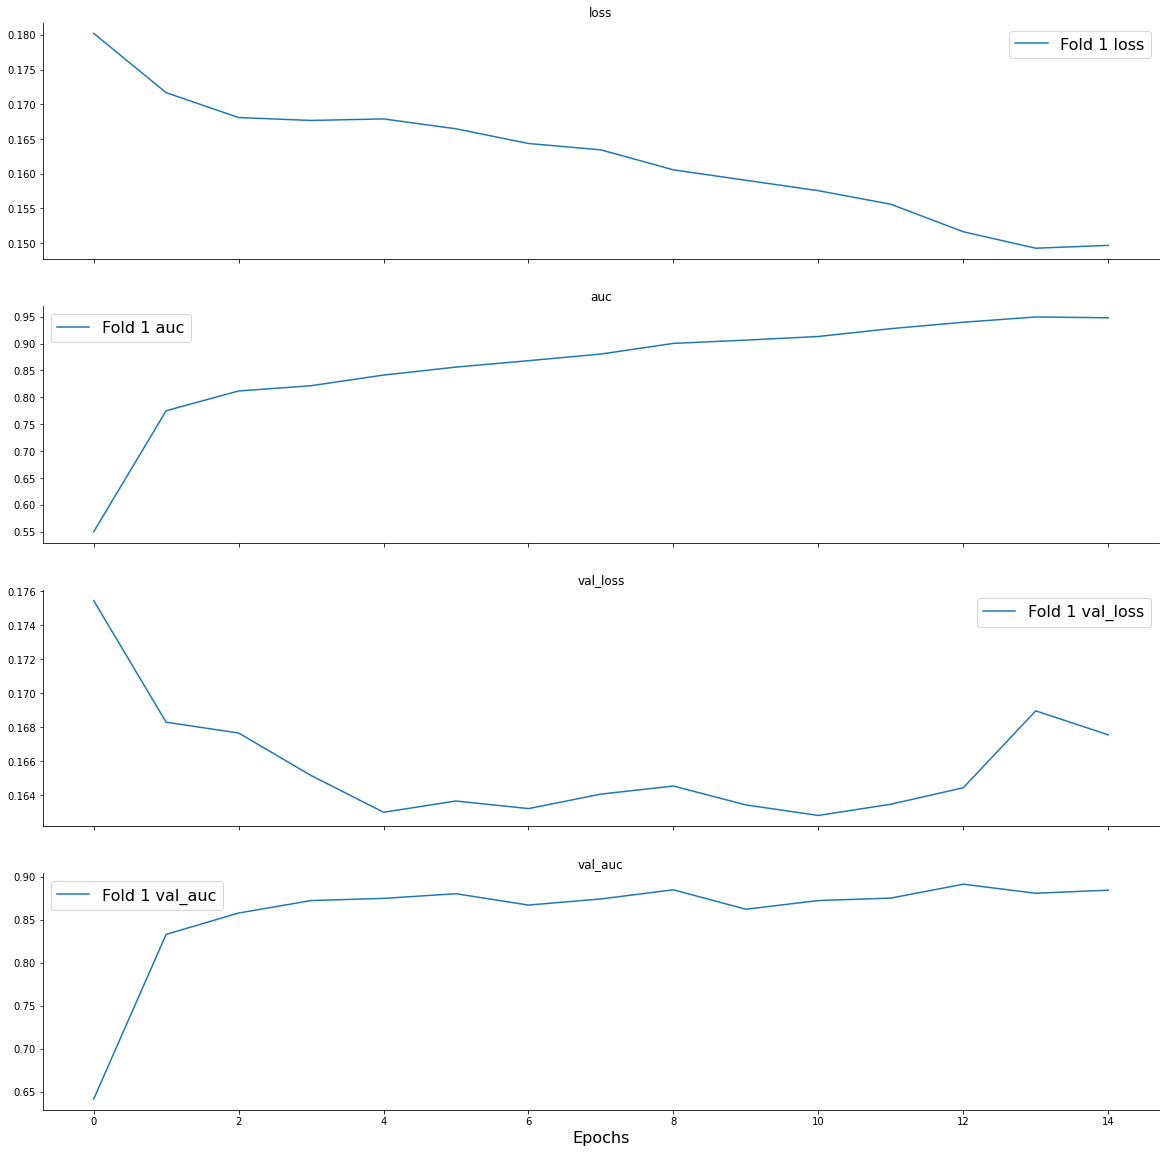

In [13]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [14]:
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric,,,,,
ROC AUC,0.984935,0.889693,0.095242,0.984935,0.889693
Accuracy,0.991550,0.980725,0.010825,0.991550,0.980725
Precision,0.849003,0.403509,0.445494,0.849003,0.403509
Recall,0.639485,0.200000,0.439485,0.639485,0.200000
F1-score,0.729498,0.267442,0.462056,0.729498,0.267442
Support,466.000000,115.000000,351.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1
Subset/ROC AUC,,,,,
Overall,0.984935,0.889693,0.095242,0.984935,0.889693
male,0.984462,0.907459,0.077003,0.984462,0.907459
female,0.985315,0.853880,0.131434,0.985315,0.853880
head/neck,0.984735,0.878225,0.106510,0.984735,0.878225
upper extremity,0.985193,0.863068,0.122125,0.985193,0.863068
lower extremity,0.977861,0.889303,0.088558,0.977861,0.889303
torso,0.987328,0.885771,0.101557,0.987328,0.885771
0 <= age < 26,0.980949,1.000000,-0.019051,0.980949,1.000000
26 <= age < 40,0.987658,0.931596,0.056062,0.987658,0.931596


# Model evaluation (last)

In [15]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric,,,,,
ROC AUC,0.985346,0.888267,0.097078,0.985346,0.888267
Accuracy,0.991627,0.980419,0.011208,0.991627,0.980419
Precision,0.809524,0.410959,0.398565,0.809524,0.410959
Recall,0.693133,0.260870,0.432263,0.693133,0.260870
F1-score,0.746821,0.319149,0.427672,0.746821,0.319149
Support,466.000000,115.000000,351.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1
Subset/ROC AUC,,,,,
Overall,0.985346,0.888267,0.097078,0.985346,0.888267
male,0.984707,0.907487,0.077220,0.984707,0.907487
female,0.986001,0.850177,0.135824,0.986001,0.850177
head/neck,0.983946,0.871738,0.112208,0.983946,0.871738
upper extremity,0.985589,0.858517,0.127071,0.985589,0.858517
lower extremity,0.978861,0.864441,0.114420,0.978861,0.864441
torso,0.987713,0.895172,0.092541,0.987713,0.895172
0 <= age < 26,0.982113,1.000000,-0.017887,0.982113,1.000000
26 <= age < 40,0.988368,0.914026,0.074341,0.988368,0.914026


# Confusion matrix

Fold: 1


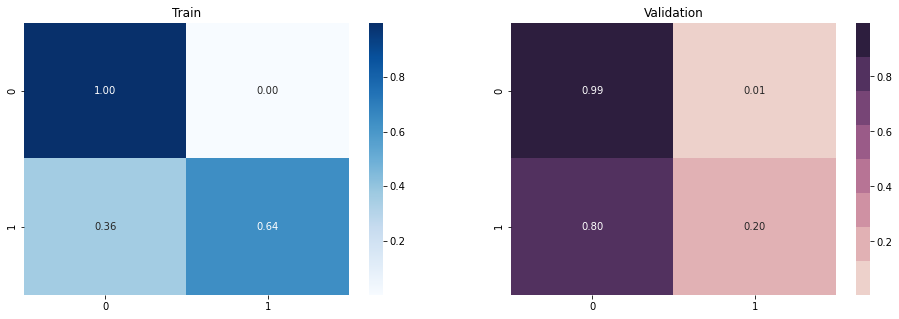

In [16]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [17]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 0
Train positive correct predictions: 0
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.015453,0.077263
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.004875,0.024375
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.005205,0.026025
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.007082,0.035409
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.004878,0.024392
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.006090,0.030451
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.006779,0.033897
7,ISIC_0075663,female,35.0,torso,unknown,0,0.005551,0.027756
8,ISIC_0075914,male,30.0,torso,unknown,0,0.006680,0.033401
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.006866,0.034332


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.024293,0.121465
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.144204,0.721021
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.193484,0.967420
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.014412,0.072061
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.196670,0.983351
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.176834,0.884170
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.020269,0.101344
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.199916,0.999579
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.188839,0.944197
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.015036,0.075181


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1


# Visualize test predictions

In [18]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 133|10849
Test predictions (last) 168|10814
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.025651,0.024376
1,ISIC_0052349,male,40.0,lower extremity,0.026700,0.024926
2,ISIC_0058510,female,55.0,torso,0.027390,0.026349
3,ISIC_0073313,female,50.0,torso,0.028041,0.026598
4,ISIC_0073502,female,45.0,lower extremity,0.034700,0.033009
5,ISIC_0074618,male,50.0,lower extremity,0.029068,0.026126
6,ISIC_0076801,male,45.0,upper extremity,0.034344,0.032076
7,ISIC_0077586,male,50.0,lower extremity,0.026796,0.027857
8,ISIC_0082004,female,45.0,torso,0.048142,0.047966
9,ISIC_0082785,male,65.0,lower extremity,0.030137,0.029712


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
69,ISIC_0182213,female,80.0,head/neck,0.517872,0.651218
175,ISIC_0274789,male,80.0,torso,0.834358,0.940504
210,ISIC_0307004,male,30.0,torso,0.636267,0.795375
290,ISIC_0385865,male,45.0,upper extremity,0.650641,0.699338
403,ISIC_0481105,male,80.0,torso,0.732204,0.728619
522,ISIC_0585534,male,70.0,head/neck,0.547473,0.665942
547,ISIC_0602633,male,50.0,head/neck,0.604679,0.544957
552,ISIC_0606244,male,70.0,torso,0.664401,0.743429
596,ISIC_0637104,female,80.0,torso,0.546287,0.688531
935,ISIC_0931237,male,70.0,upper extremity,0.542786,0.653543


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
42,ISIC_0155983,male,70.0,torso,0.435403,0.734702
69,ISIC_0182213,female,80.0,head/neck,0.517872,0.651218
175,ISIC_0274789,male,80.0,torso,0.834358,0.940504
210,ISIC_0307004,male,30.0,torso,0.636267,0.795375
290,ISIC_0385865,male,45.0,upper extremity,0.650641,0.699338
403,ISIC_0481105,male,80.0,torso,0.732204,0.728619
522,ISIC_0585534,male,70.0,head/neck,0.547473,0.665942
547,ISIC_0602633,male,50.0,head/neck,0.604679,0.544957
552,ISIC_0606244,male,70.0,torso,0.664401,0.743429
596,ISIC_0637104,female,80.0,torso,0.546287,0.688531


# Test set predictions

In [19]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv('submission.csv', index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv('submission_last.csv', index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv('submission_blend.csv', index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.025651,0.024376,0.025013
1,ISIC_0052349,0.026700,0.024926,0.025813
2,ISIC_0058510,0.027390,0.026349,0.026869
3,ISIC_0073313,0.028041,0.026598,0.027319
4,ISIC_0073502,0.034700,0.033009,0.033854
5,ISIC_0074618,0.029068,0.026126,0.027597
6,ISIC_0076801,0.034344,0.032076,0.033210
7,ISIC_0077586,0.026796,0.027857,0.027326
8,ISIC_0082004,0.048142,0.047966,0.048054
9,ISIC_0082785,0.030137,0.029712,0.029925


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.050970,0.051278,0.051124
std,0.091339,0.101733,0.095998
min,0.017553,0.015162,0.016358
25%,0.027685,0.025905,0.026817
50%,0.030666,0.028780,0.029722
75%,0.037623,0.035109,0.036460
max,0.999753,0.999992,0.999872
